In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
batch_size = 32
image_size = 256
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5
train_percentage, val_percentage, test_percentage = 60, 20, 20
directory_root = './dataset'

In [3]:
import os
from PIL import Image

images, labels = [], []
try:
    for label_name in os.listdir(directory_root):
        logging.info(f"Processing {label_name} ...")
        label_path = os.path.join(directory_root, label_name)
        if not os.path.isdir(label_path):
            continue

        for image_name in os.listdir(label_path):
            try:
                if image_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(label_path, image_name)
                    Image.open(image_path)  # Check if the image can be opened
                    images.append(image_path)
                    labels.append(label_name)
            except UnidentifiedImageError:
                logging.error(f"Unidentified image file: {image_path}")
            except Exception as e:
                logging.error(f"Error processing {image_path}: {e}")
except Exception as e:
    logging.critical(f"Failed to load images: {e}")

if not images:
    raise ValueError("No images found. Please check the dataset directory structure.")

logging.info("Image paths and labels loaded successfully.")

2024-11-16 05:36:49,862 - INFO - Processing .ipynb_checkpoints ...
2024-11-16 05:36:49,862 - INFO - Processing Apple___Cedar_apple_rust ...
2024-11-16 05:36:49,948 - INFO - Processing Apple___healthy ...
2024-11-16 05:36:50,028 - INFO - Processing Corn_(maize)___Common_rust ...
2024-11-16 05:36:50,103 - INFO - Processing Corn_(maize)___healthy ...
2024-11-16 05:36:50,178 - INFO - Processing Grape___Esca_(Black_Measles) ...
2024-11-16 05:36:50,255 - INFO - Processing Grape___healthy ...
2024-11-16 05:36:50,332 - INFO - Processing Peach___Bacterial_spot ...
2024-11-16 05:36:50,412 - INFO - Processing Peach___healthy ...
2024-11-16 05:36:50,487 - INFO - Processing Raspberry___healthy ...
2024-11-16 05:36:50,564 - INFO - Processing Tomato___healthy ...
2024-11-16 05:36:50,641 - INFO - Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
2024-11-16 05:36:50,718 - INFO - Image paths and labels loaded successfully.


In [4]:
import pandas as pd

labels_df = pd.DataFrame({'labels': labels})
unique_labels = set(labels_df['labels'])
label_counts = labels_df['labels'].value_counts()

for label in unique_labels:
    count = label_counts.get(label, 0)
    logging.info(f"Label: {label}, Count: {count}")

2024-11-16 05:36:50,935 - INFO - Label: Peach___Bacterial_spot, Count: 275
2024-11-16 05:36:50,935 - INFO - Label: Grape___healthy, Count: 275
2024-11-16 05:36:50,936 - INFO - Label: Corn_(maize)___Common_rust, Count: 275
2024-11-16 05:36:50,936 - INFO - Label: Tomato___healthy, Count: 275
2024-11-16 05:36:50,936 - INFO - Label: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Count: 275
2024-11-16 05:36:50,936 - INFO - Label: Raspberry___healthy, Count: 275
2024-11-16 05:36:50,936 - INFO - Label: Corn_(maize)___healthy, Count: 275
2024-11-16 05:36:50,937 - INFO - Label: Peach___healthy, Count: 275
2024-11-16 05:36:50,937 - INFO - Label: Grape___Esca_(Black_Measles), Count: 275
2024-11-16 05:36:50,937 - INFO - Label: Apple___healthy, Count: 275
2024-11-16 05:36:50,937 - INFO - Label: Apple___Cedar_apple_rust, Count: 275


In [5]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

images = np.array(images)
labels = np.array(labels)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels_encoded))

joblib.dump(label_encoder, './label_encoder.pkl')

if train_percentage + val_percentage + test_percentage != 100:
    raise ValueError("The sum of train, val, and test percentages must be 100.")

try:
    train_files, test_files, train_labels, test_labels = train_test_split(
        images, labels_encoded, test_size=test_percentage / 100, random_state=42, stratify=labels_encoded
    )
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=val_percentage / (train_percentage + val_percentage), random_state=42, stratify=train_labels
    )
except ValueError as e:
    logging.critical(f"Error in data splitting: {e}")
    raise

In [6]:
import zipfile

try:
    np.save('train_labels.npy', train_labels)
    np.save('val_labels.npy', val_labels)
    np.save('test_labels.npy', test_labels)
    with zipfile.ZipFile('./labels.zip', 'w') as zipf:
        zipf.write('train_labels.npy')
        zipf.write('val_labels.npy')
        zipf.write('test_labels.npy')
    logging.info("Label arrays saved and zipped successfully.")
except Exception as e:
    logging.error(f"Error saving label arrays: {e}")

2024-11-16 05:36:51,268 - INFO - Label arrays saved and zipped successfully.


In [7]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

In [9]:
class PlantDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.file_paths[idx]).convert("RGB")
        except FileNotFoundError:
            logging.error(f"File not found: {self.file_paths[idx]}")
            raise
        except UnidentifiedImageError:
            logging.error(f"Unidentified image file: {self.file_paths[idx]}")
            raise
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

try:
    train_dataset = PlantDataset(train_files, train_labels, transform=transform_train)
    val_dataset = PlantDataset(val_files, val_labels, transform=transform_test)
    test_dataset = PlantDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    logging.info("Data loaders created successfully.")
except Exception as e:
    logging.error(f"Error creating data loaders: {e}")
    raise

logging.info(f"Train set size - {len(train_dataset)}")
logging.info(f"Validation set size - {len(val_dataset)}")
logging.info(f"Test set size - {len(test_dataset)}")

2024-11-16 05:36:52,927 - INFO - Data loaders created successfully.
2024-11-16 05:36:52,927 - INFO - Train set size - 1815
2024-11-16 05:36:52,928 - INFO - Validation set size - 605
2024-11-16 05:36:52,928 - INFO - Test set size - 605


In [10]:
from torch import Tensor
import torch.nn as nn
from timm.layers import DropPath, to_2tuple
from typing import List, Optional, Tuple

In [11]:
class PositionalEmbedding(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, patch_size: int):
        super(PositionalEmbedding, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        patch_size = to_2tuple(patch_size)
        # num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])
        self.patch_size = patch_size
        # self.num_patches = num_patches
        # Define layers
        self.patch_proj = nn.Conv2d(in_channels, out_channels, kernel_size=patch_size, stride=patch_size)
        self.activation = nn.ReLU(inplace=True)
        self.embed = None 
        
    def forward(self, x: Tensor) -> Tuple[Tensor, int, int]:
        B, C, H, W = x.shape
        # print(f"PositionalEmbedding Input Shape: B={B}, C={C}, H={H}, W={W}")
        assert H >= self.patch_size[0] and W >= self.patch_size[1], (
            f"Input height and width (H={H}, W={W}) must be >= patch size {self.patch_size}."
        )
        num_patches = (H // self.patch_size[0]) * (W // self.patch_size[1])

        # Create positional embeddings dynamically based on the number of patches
        if self.embed is None or self.embed.num_embeddings != num_patches:
            self.embed = nn.Embedding(num_patches, self.out_channels).to(x.device)

        x = self.patch_proj(x)
        x = self.activation(x)
        H, W = x.shape[-2:]
        x = x.flatten(2).permute(0, 2, 1)
        
        pos_embeddings = self.embed(torch.arange(num_patches, device=x.device))
        x = x + pos_embeddings
        # print(f"PositionalEmbedding Output Shape: {x.shape}, H={H}, W={W}\n")
        return x, H, W

In [12]:
class ViTBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_heads,
                 mlp_ratio: float =4.0,
                 dropout_rate: float=0.1, 
                 drop_path: float = 0.0
                ) -> None:
        super().__init__()
        self.attn_layer_norm = nn.LayerNorm(in_channels, eps=1e-6)

        # Ensure in_features and out_features are integers
        self.in_features = in_channels
        self.out_features = out_channels
        
        # Linear projections for query, key, and value
        self.query_proj = nn.Linear(in_channels, out_channels)
        self.key_proj = nn.Linear(in_channels, out_channels)
        self.value_proj = nn.Linear(in_channels, out_channels)
        
        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, dropout=dropout_rate)
        self.attn_drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        self.ffn_layer_norm = nn.LayerNorm(in_channels, eps=1e-6)
        
        # Feed-forward network (FFN)
        hidden_features = int(out_channels * mlp_ratio)
        self.ffn = nn.Sequential(
            nn.Linear(in_channels, hidden_features),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_features, out_channels)
        )
        self.ffn_drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() == 3, f"Input must have 3 dimensions (B, N, C), but got shape {x.shape}"
        x = self.attn_layer_norm(x)
        
        query = self.query_proj(x)
        key = self.key_proj(x)
        value = self.value_proj(x)
        
        attn_output, _ = self.attention(query, key, value)
        x = self.attn_drop_path(attn_output).add(x)
        
        x = self.ffn_layer_norm(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.ffn_drop_path(ffn_output).add(x)
        
        return x

In [13]:
class ViTStem(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
    ):
        super().__init__()
        kernel_size = to_2tuple(kernel_size)
        stride = to_2tuple(stride)
        dilation = to_2tuple(dilation)

        padding = [
            (dilation[i] * (kernel_size[i] - 1) + 1) // 2 for i in range(len(kernel_size))
        ]

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels // 2,
            kernel_size,
            stride=(stride[0] // 2, stride[1] // 2),  # Reduced stride for less downsampling
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.act1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels // 2,
            out_channels,
            kernel_size,
            stride=(stride[0] // 2, stride[1] // 2),
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act2 = nn.ReLU(inplace=True)

    def forward(self, x):
        assert x.dim() == 4, f"Input must have 4 dimensions (B, C, H, W), but got shape {x.shape}"
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))

        return x

In [14]:
if __name__ == '__main__':
    stem = ViTStem(in_channels=3, out_channels=64)
    sample_input = torch.randn(1, 3, 256, 256)
    output = stem(sample_input)
    print(output.shape)
    
    pos_embedding = PositionalEmbedding(in_channels=64, out_channels=64, patch_size=16)
    output, h, w = pos_embedding(output)
    print(output.shape, h , w)  # Should be (B, num_patches, out_channels)
    
    vit_block = ViTBlock(in_channels=64, out_channels=64, num_heads=4)
    output = vit_block(output)
    output = output.reshape(1, h, w, -1).permute(0, 3, 1, 2).contiguous()
    print(output.shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 256, 64]) 16 16
torch.Size([1, 64, 16, 16])


In [15]:
class ViTStage(nn.Module):
    def __init__(
        self,
        patch_size: int = 16,
        in_channels: Tuple[
            int,
        ] = (32, 64, 128, 256),
        out_channels: Tuple[
            int,
        ] = (32, 64, 128, 256),
        block_list: Tuple[
            int,
        ] = (1, 2, 3, 1),
        dim_head: int = 32,
        dropout_rate: float = 0.0,
        drop_path_rates: Tuple[float] = (
            0.0, 0.0, 0.0,
        ),
        mlp_ratio_list: Tuple[float] = (
            4, 4, 4, 4
        ),
    ) -> None:
        super().__init__()
        assert len(in_channels) == len(out_channels), "in_channels should be equal to out_channels"
        
        self.embeddings = nn.ModuleList(
            [
                PositionalEmbedding(
                    in_channels=in_c,
                    out_channels=out_c,
                    patch_size=patch_size
                )
                for in_c, out_c in zip(in_channels, out_channels)
            ]
        )

        n_inputs = len(out_channels)
        self.branches = nn.ModuleList([])

        for i, n_blocks in enumerate(block_list[:n_inputs]):
            blocks = []
            for j in range(n_blocks):
                blocks += [
                    ViTBlock(
                        in_channels = out_channels[i],
                        out_channels = out_channels[i],
                        num_heads = out_channels[i] // dim_head,
                        dropout_rate=dropout_rate,
                        mlp_ratio=mlp_ratio_list[i],
                        drop_path=drop_path_rates[j],
                    )
                ]
            blocks = nn.ModuleList(blocks)
            self.branches.append(blocks)
        
        self.norm = nn.ModuleList(
            [
                nn.LayerNorm(out_c) 
                for in_c, out_c in zip(in_channels, out_channels)
            ]
        )
    
    def forward(
        self,
        x: Tuple[
            Tensor,
        ],
    ) -> Tuple[Tensor,]:
        B = x[0].shape[0]
        x = list(x)
        H, W = [], []
        for i, (x_i, embedding) in enumerate(zip(x, self.embeddings)):
            # print(f"ViTStage Embedding Stage {i}\n")
            x_i, h, w = embedding(x_i)
            x[i] = x_i
            H.append(h)
            W.append(w)
        
        for i, branch in enumerate(self.branches):
            # print(f"ViTStage Transformation Stage {i}\n")
            for block in branch:
                x[i] = block(x[i])
            
        for i, (x_i, norm, h, w) in enumerate(zip(x, self.norm, H, W)):
            # print(f"ViTStage Norm and Reshape Stage {i}")
            x_i = norm(x_i)
            x_i = x_i.reshape(B, h, w, -1).permute(0, 3, 1, 2).contiguous()
            x[i] = x_i
            # print(f"{x_i.shape}\n")

        return x

In [16]:
if __name__ == '__main__':
    stage = ViTStage(patch_size=4)
    batch_size = 2
    input_shapes = [(32, 64, 64), (64, 64, 64), (128, 64, 64), (256, 64, 64)]
    sample_input = [torch.randn(batch_size, *shape) for shape in input_shapes]

    output = stage(sample_input)
    
    for i, out in enumerate(output):
        print(f"Output {i+1}: {out.shape}")

    # print(stage)

Output 1: torch.Size([2, 32, 16, 16])
Output 2: torch.Size([2, 64, 16, 16])
Output 3: torch.Size([2, 128, 16, 16])
Output 4: torch.Size([2, 256, 16, 16])


In [17]:
class FusionBlock(nn.Module):
    def __init__(
        self,
        in_channels: Tuple[int] = (32, 64, 128, 256),
        out_channels: Tuple[int] = (32, 64, 128, 256)
    ) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self._build_fuse_layers()

    def _build_fuse_layers(self):
        self.fuse_layers = nn.ModuleList([])
        for i in range(len(self.out_channels)): # outputs layer
            fuse_layer = nn.ModuleList([])
            for j in range(len(self.in_channels)): # input layer
                if j == i:
                    fuse_layer.append(nn.Identity())
                elif j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(
                            self.in_channels[j],
                            self.out_channels[i],
                            kernel_size=1,
                            stride=1,
                            dilation=1,
                            padding=0,
                            groups=1,
                            bias=True,
                        ),
                        nn.BatchNorm2d(self.out_channels[i]),
                        nn.Upsample(
                            scale_factor=2 ** (j - i),
                            mode="nearest",
                        )
                    ))
                else:
                    # direct downsampling to minimize overhead
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(
                            self.in_channels[j],
                            self.in_channels[j],
                            kernel_size = 2 ** (i - j) + 1,
                            stride = 2 ** (i - j),
                            dilation = 1,
                            padding = 2 ** (i - j) // 2,
                            groups = self.in_channels[j],
                            bias = False,
                        ),
                        nn.BatchNorm2d(self.in_channels[j]),
                        nn.Conv2d(
                            self.in_channels[j],
                            self.out_channels[i],
                            kernel_size=1,
                            stride=1,
                            dilation=1,
                            padding=0,
                            groups=1,
                            bias=True,
                        ),
                        nn.BatchNorm2d(self.out_channels[i])
                    ))
            self.fuse_layers.append(fuse_layer)

        self.activations = nn.ModuleList([nn.ReLU() for _ in self.out_channels])

    def forward(
        self,
        x: Tuple[
            Tensor,
        ],
    ) -> Tuple[Tensor,]:
        # print(f"FusionBlock: ")
        for idx, tensor in enumerate(x):
            # print(f"Input {idx} Shape: {tensor.shape}")
            assert tensor.dim() == 4, f"Input {idx} must have 4 dimensions (B, C, H, W), but got shape {tensor.shape}"
        out = [None] * len(self.fuse_layers)
        for i, (fuse_layers, activation) in enumerate(zip(self.fuse_layers, self.activations)):
            for j, fuse_layer in zip(range(len(x)), fuse_layers):
                # print(f"Input {j} to Output {i}")
                fused_output = fuse_layer(x[j])
                # print(f"Output Shape: {fused_output.shape}")
                out[i] = fused_output if out[i] is None else out[i] + fused_output
            out[i] = activation(out[i])
            # print(f"Output {i} Shape: {out[i].shape}\n")
        return out

In [18]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.1)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.1)
        
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=0.1)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    planes * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    dilation=1,
                    padding=0,
                    groups=1,
                    bias=False,
                ),
                nn.BatchNorm2d(
                    planes * self.expansion,
                    momentum = 0.1,
                ),
            )

        self.stride = stride
        
    def forward(self, x: Tensor) -> Tensor:
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        
        return out

In [19]:
class Classifier(nn.Module):
    def __init__(
        self,
        in_channels: Tuple[int] = (32, 64, 128, 256),
        head_channels: Tuple[int] = (64, 128, 256, 256),
        num_classes: int = 1000,
        dropout: float = 0.0,
    ):
        super(Classifier, self).__init__()
        
        head_block = Bottleneck
        self.head_channels = head_channels
        
        # Increasing the #channels on each resolution
        # from C, 2C, 4C, 8C to 128, 256, 512, 1024
        incre_modules = []
        for i, channels in enumerate(in_channels):
            incre_module = self._make_layer(
                head_block,
                channels,
                head_channels[i],
                1,
                stride=1,
            )
            incre_modules.append(incre_module)
        self.incre_modules = nn.ModuleList(incre_modules)

        # downsampling modules
        downsamp_modules = []
        for i in range(len(in_channels) - 1):
            in_c = head_channels[i] * head_block.expansion
            out_c = head_channels[i + 1] * head_block.expansion
            downsamp_module = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_c,
                    out_channels=out_c,
                    kernel_size=3,
                    stride=2,
                    dilation=1,
                    padding=1,
                    groups=1,
                    bias=True,
                ),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
            downsamp_modules.append(downsamp_module)
        self.downsamp_modules = nn.ModuleList(downsamp_modules)
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=head_channels[-1] * head_block.expansion,
                out_channels=2048,
                kernel_size=1,
                stride=1,
                dilation=1,
                padding=0,
                groups=1,
                bias=True,
            ),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = (
            nn.Linear(2048, num_classes) if num_classes > 0 else nn.Identity()
        )
        
    def _make_layer(
        self, block: nn.Module, inplanes: int, planes: int, blocks: int, stride: int = 1
    ) -> nn.Module:
        layers = []
        layers.append(
            block(
                inplanes=inplanes,
                planes=planes,
                stride=stride,
            )
        )
        inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    inplanes,
                    planes,
                )
            )

        return nn.Sequential(*layers)

    def forward(
        self,
        y_list: Tuple[
            Tensor,
        ],
    ) -> Tensor:
        # Classification Head
        y = self.incre_modules[0](y_list[0])
        for i in range(len(self.downsamp_modules)):
            y = self.incre_modules[i + 1](y_list[i + 1]) + self.downsamp_modules[i](y)

        y = self.final_layer(y)

        y = self.pool(y).flatten(1)
        y = self.dropout(y)
        y = self.classifier(y)
        return y

In [20]:
class HRViTaL(nn.Module):
    def __init__(
        self,
        ### ViT Stem Config ###
        in_channels: int = 3,
        out_channels: int = 32,
        patch_size: int = 16,
        ### Branch Config ###
        channel_list: Tuple[Tuple[int,],] = (
            (32,),
            (32, 64),
            (32, 64, 128),
            (32, 64, 128),
            (32, 64, 128, 256),
            (32, 64, 128, 256),
        ),
        block_list: Tuple[Tuple[int]] = (
            (1,),
            (1, 1),
            (1, 1, 2),
            (1, 1, 2),
            (1, 1, 2, 2),
            (1, 1, 2, 2),
        ),
        #### Attention Config ####
        dim_head: int = 32,
        proj_dropout: float = 0.0,
        drop_path_rate: float = 0.0,
        #### FeedForward Config ####
        mlp_ratio_list: Tuple[
            int,
        ] = (4, 4, 4, 4),
        mlp_dropout: float = 0.0,
        #### Classification Head Config ####
        num_classes: int = 1000,
        head_channels: Tuple[int] = (64, 128, 256, 256),
        head_dropout: float = 0.1,
    ) -> None:
        super(HRViTaL, self).__init__()

        self.stem = ViTStem(in_channels, out_channels, patch_size)

        total_blocks = sum(max(b) for b in block_list)
        total_drop_path_rates = (
            torch.linspace(0, drop_path_rate, total_blocks).numpy().tolist()
        )
        current_drop_path_rate = 0

        
        self.channel_list = channel_list = [[out_channels]] + list(channel_list)

        features = []
        for i, blocks in enumerate(block_list):
            inc, outc = channel_list[i : i + 2]
            depth_per_stage = max(blocks)

            features.extend(
                [
                    FusionBlock(
                        in_channels=inc,
                        out_channels=inc
                        if len(inc) == len(outc)
                        else list(inc) + [outc[-1]],
                    ),
                    ViTStage(
                        #### Patch Embed Config ####
                        patch_size,
                        in_channels = inc if len(inc) == len(outc) else list(inc) + [outc[-1]],
                        out_channels = outc,
                        block_list = blocks,
                        dim_head = dim_head,
                        #### HRViTBlock Config ####
                        drop_path_rates=total_drop_path_rates[current_drop_path_rate : current_drop_path_rate + depth_per_stage],
                        mlp_ratio_list=mlp_ratio_list,
                        dropout_rate=mlp_dropout,
                    ),                   
                ]
            )
            current_drop_path_rate += depth_per_stage

        self.features = nn.Sequential(*features)
        
        self.head = Classifier(
            in_channels=channel_list[-1],
            head_channels=head_channels,
            num_classes=num_classes,
            dropout=head_dropout,
        )

    def forward(self, x: Tensor) -> Tensor:
        # stem
        x = self.stem(x)
        # backbone
        x = self.features((x,))
        # classifier
        x = self.head(x)
        return x

In [21]:
import torch.optim as optim
from tqdm import tqdm

try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    model = HRViTaL(
        in_channels=3,
        out_channels=64,
        dim_head=32,
        patch_size=4,
        drop_path_rate=0.2,
        channel_list=(
            (32,),
            (32, 64),
            (32, 64),
        ),
        block_list=(
            (1,),
            (1, 2),
            (1, 2)
        ),
        mlp_ratio_list=(4, 4, 4, 4),
        mlp_dropout=0.2,
        head_channels=(16, 32, 32, 32),
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    logging.info("Model and optimizer initialized successfully.")
except Exception as e:
    logging.error(f"Error initializing model or optimizer: {e}")
    raise

2024-11-16 05:36:53,634 - INFO - Using device: cuda
2024-11-16 05:36:53,786 - INFO - Model and optimizer initialized successfully.


In [22]:
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0
best_model_state = None

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    logging.info(f'Starting epoch {epoch + 1}/{num_epochs}')

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        try:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        except Exception as e:
            logging.error(f"Error during training iteration: {e}")

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    logging.info(f"Epoch {epoch + 1} - Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
            except Exception as e:
                logging.error(f"Error during validation iteration: {e}")


    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    logging.info(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            logging.info("Early stopping triggered!")
            break

logging.info("Training complete.")

try:
    if best_model_state:
        model.load_state_dict(best_model_state)
        logging.info("Best model state loaded successfully.")
except Exception as e:
    logging.error(f"Error loading the best model state: {e}")

2024-11-16 05:36:53,793 - INFO - Starting epoch 1/50
2024-11-16 05:37:07,238 - INFO - Epoch 1 - Training Loss: 2.4187 Acc: 0.0915                                                                                                                                                            
2024-11-16 05:37:08,735 - INFO - Epoch 1 - Validation Loss: 2.3655 Acc: 0.0975                                                                                                                                                          
2024-11-16 05:37:08,737 - INFO - Starting epoch 2/50
2024-11-16 05:37:21,839 - INFO - Epoch 2 - Training Loss: 2.2726 Acc: 0.2072                                                                                                                                                            
2024-11-16 05:37:23,351 - INFO - Epoch 2 - Validation Loss: 1.9156 Acc: 0.3719                                                                                                                     

In [29]:
try:
    history_df = pd.DataFrame({
        'loss': train_losses,
        'val_loss': val_losses,
        'accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    })
    history_df.to_csv("./report/training_history.csv", index=False)
    logging.info("Training history saved successfully.")
except Exception as e:
    logging.error(f"Error saving training history: {e}")

2024-11-16 05:49:40,852 - INFO - Training history saved successfully.


2024-11-16 05:49:42,402 - INFO - Loss curves saved as 'loss_curves.jpg'


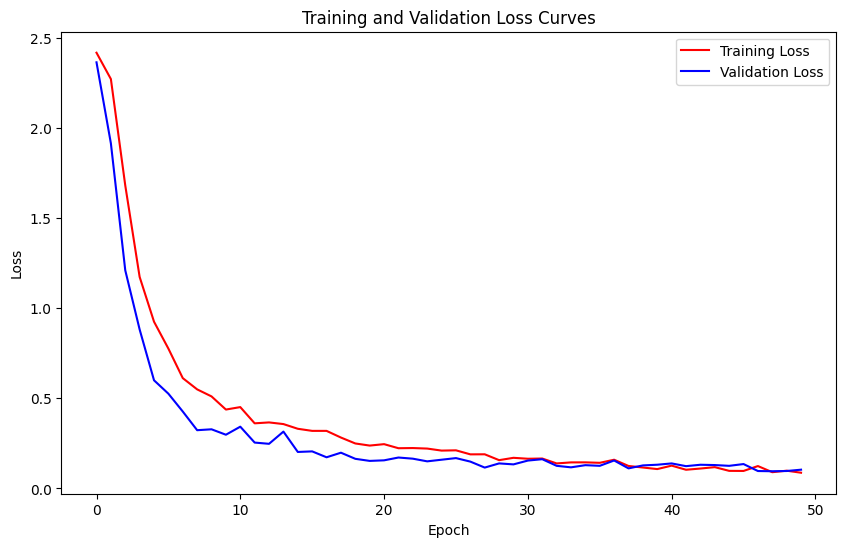

In [30]:
import matplotlib.pyplot as plt

try:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.savefig('./report/loss_curves.jpg')
    logging.info("Loss curves saved as 'loss_curves.jpg'")
    plt.show()
except Exception as e:
    logging.error(f"Error plotting loss curves: {e}")

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, hamming_loss, precision_recall_fscore_support
import seaborn as sns

model.eval()
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        try:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        except Exception as e:
            logging.error(f"Error during test evaluation: {e}")


test_loss = test_loss / len(test_dataset)
test_accuracy = test_corrects.double() / len(test_dataset)
logging.info(f"Test Loss: {test_loss:.4f}")
logging.info(f"Test Accuracy: {test_accuracy * 100:.2f}%")

try:
    test_metrics_df = pd.DataFrame({
        'Test Loss': [test_loss],
        'Test Accuracy': [test_accuracy.item()]
    })
    test_metrics_df.to_csv("./report/test_metrics.csv", index=False)
    logging.info("Test metrics saved successfully.")
except Exception as e:
    logging.error(f"Error saving test metrics: {e}")

2024-11-16 05:49:46,006 - INFO - Test Loss: 0.0969
2024-11-16 05:49:46,007 - INFO - Test Accuracy: 97.52%
2024-11-16 05:49:46,010 - INFO - Test metrics saved successfully.


2024-11-16 05:49:46,187 - INFO - Confusion matrix saved as 'confusion_matrix.jpg'


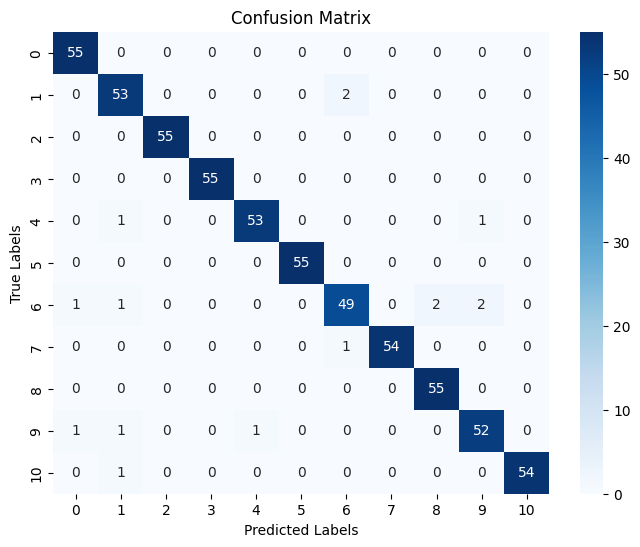

2024-11-16 05:49:46,668 - INFO - Confusion matrix saved as 'confusion_matrix_with_labels.jpg'


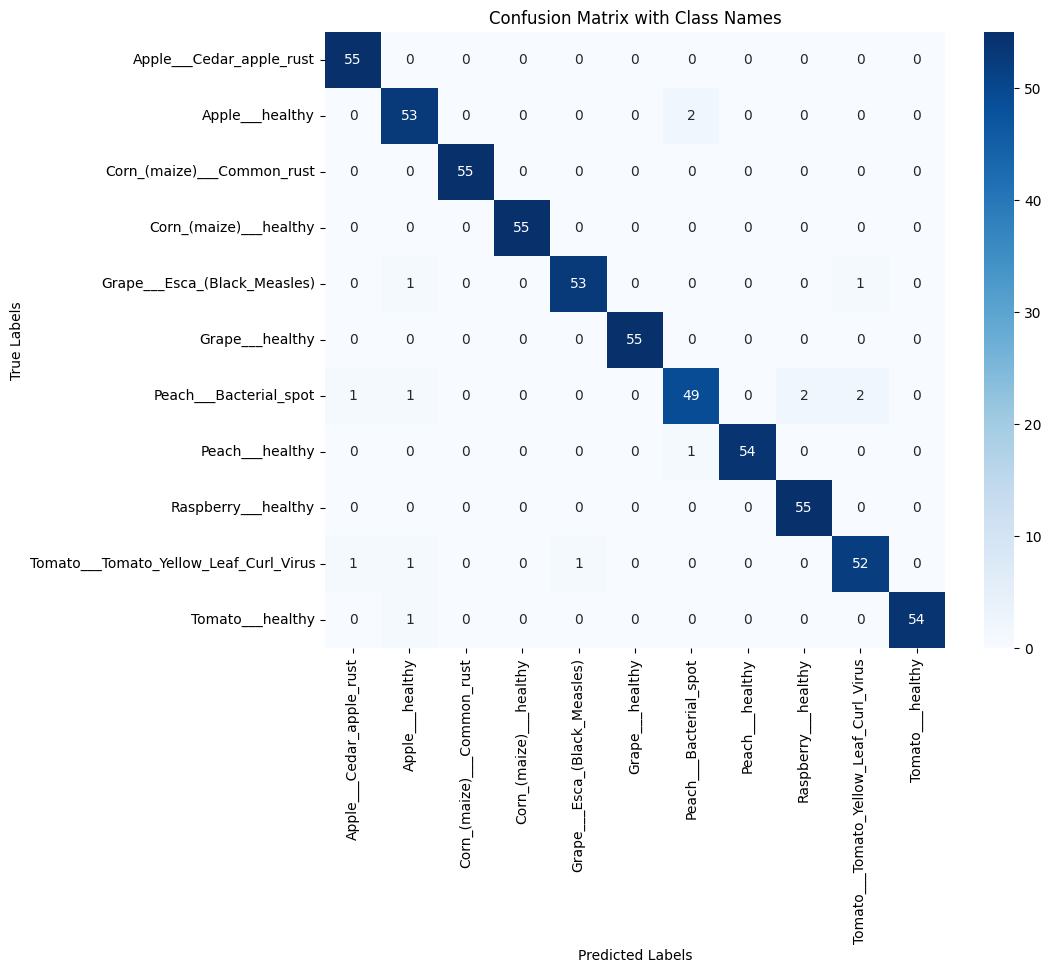

In [32]:
try:
    cm = confusion_matrix(all_labels, all_preds)
    loaded_label_encoder = joblib.load('./label_encoder.pkl')
    class_names = loaded_label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('./report/confusion_matrix.jpg')
    logging.info("Confusion matrix saved as 'confusion_matrix.jpg'")
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix with Class Names')
    plt.savefig('./report/confusion_matrix_with_labels.jpg')
    logging.info("Confusion matrix saved as 'confusion_matrix_with_labels.jpg'")
    plt.show()
except Exception as e:
    logging.error(f"Error generating confusion matrix: {e}")

In [33]:
logging.info("\nClassification Report:\n" + classification_report(all_labels, all_preds, target_names=class_names))

# Precision, Recall, F1-score
precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
micro_precision, micro_recall, micro_f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
macro_precision, macro_recall, macro_f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
hamming_loss_value = hamming_loss(all_labels, all_preds)

# Print individual class metrics
for i, class_name in enumerate(class_names):
    logging.info(f"Class: {class_name}\nPrecision: {precision[i]:.3f}\nRecall: {recall[i]:.3f}\nF1-score: {f1_score[i]:.3f}\nSupport: {support[i]}\n")
    
logging.info(f"\nMicro-Averaged Metrics:\nPrecision: {micro_precision:.2f}\nRecall: {micro_recall:.2f}\nF1-score: {micro_f1_score:.2f}")

logging.info(f"\nMacro-Averaged Metrics:\nPrecision: {macro_precision:.3f}\nRecall: {macro_recall:.3f}\nF1-score: {macro_f1_score:.3f}")

logging.info(f"\nHamming Loss: {hamming_loss_value:.3f}")

2024-11-16 05:49:50,345 - INFO - 
Classification Report:
                                        precision    recall  f1-score   support

              Apple___Cedar_apple_rust       0.96      1.00      0.98        55
                       Apple___healthy       0.93      0.96      0.95        55
            Corn_(maize)___Common_rust       1.00      1.00      1.00        55
                Corn_(maize)___healthy       1.00      1.00      1.00        55
          Grape___Esca_(Black_Measles)       0.98      0.96      0.97        55
                       Grape___healthy       1.00      1.00      1.00        55
                Peach___Bacterial_spot       0.94      0.89      0.92        55
                       Peach___healthy       1.00      0.98      0.99        55
                   Raspberry___healthy       0.96      1.00      0.98        55
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.95      0.95      0.95        55
                      Tomato___healthy       1.00      0.98   

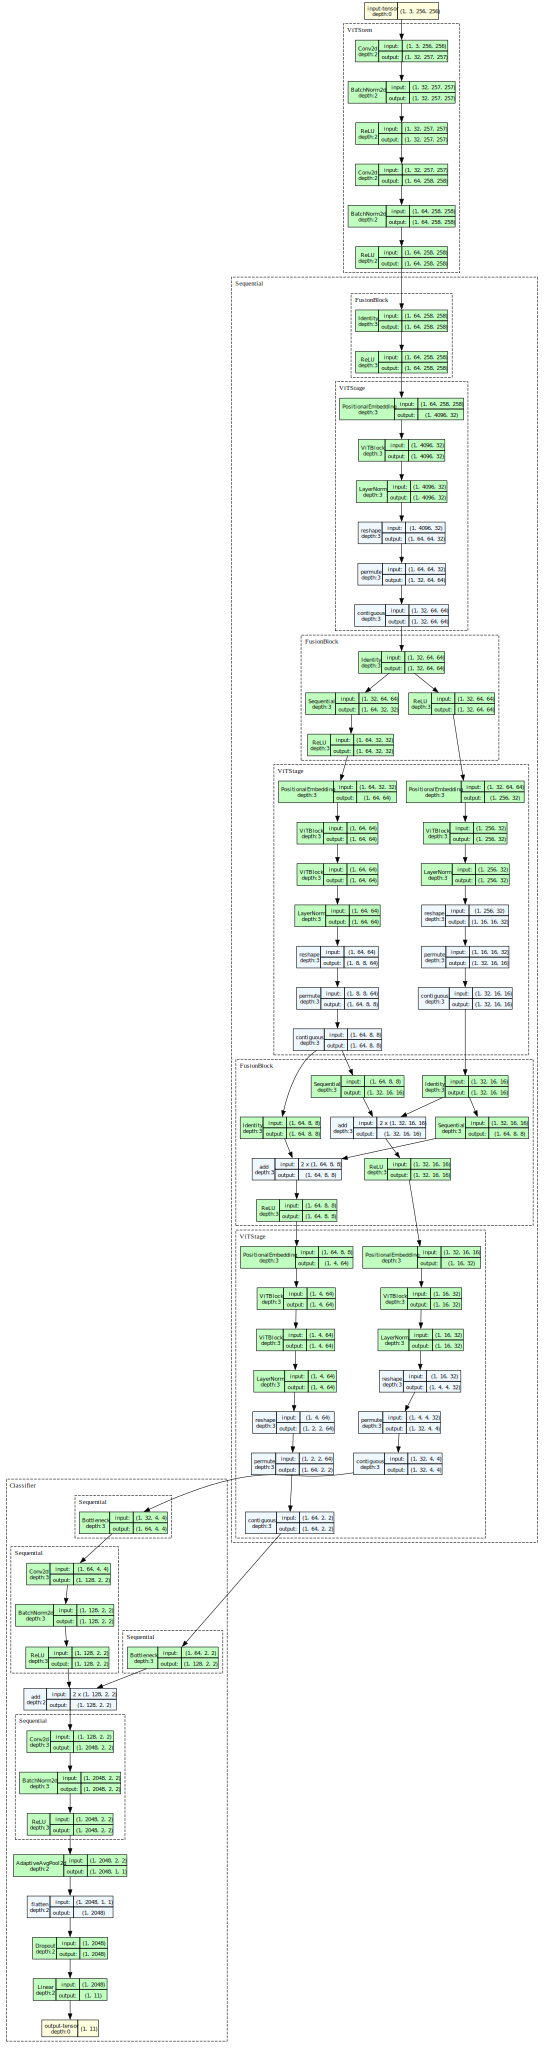

In [34]:
import torchview

model_viz = torchview.draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True)
model_viz.visual_graph